In [28]:
###
# Core Analysis (Mandatory)
###

# import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az

In [5]:
# Load raw data
df = pd.read_csv("../data/raw/BrentOilPrices.csv",
                 parse_dates=["Date"],
                 index_col="Date")

df = df.sort_index()
df = df.asfreq("D")
df["Price"] = df["Price"].interpolate()
df = df.dropna()

df.head()

C:\Users\HP EliteBook\AppData\Local\Temp\ipykernel_5536\285098912.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("../data/raw/BrentOilPrices.csv",


,Price
Date,
1987-05-20,18.630000
1987-05-21,18.450000
1987-05-22,18.550000
1987-05-23,18.566667
1987-05-24,18.583333


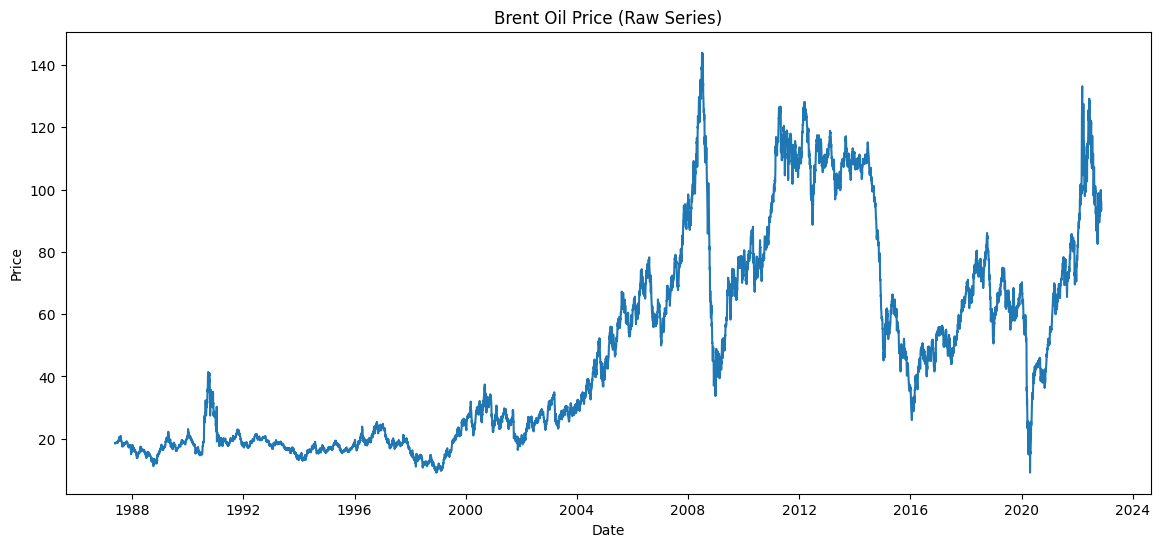

In [6]:
#plot raw price series
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"])
plt.title("Brent Oil Price (Raw Series)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [7]:
#Compute Log Returns
df["LogReturn"] = np.log(df["Price"]).diff()
df = df.dropna()

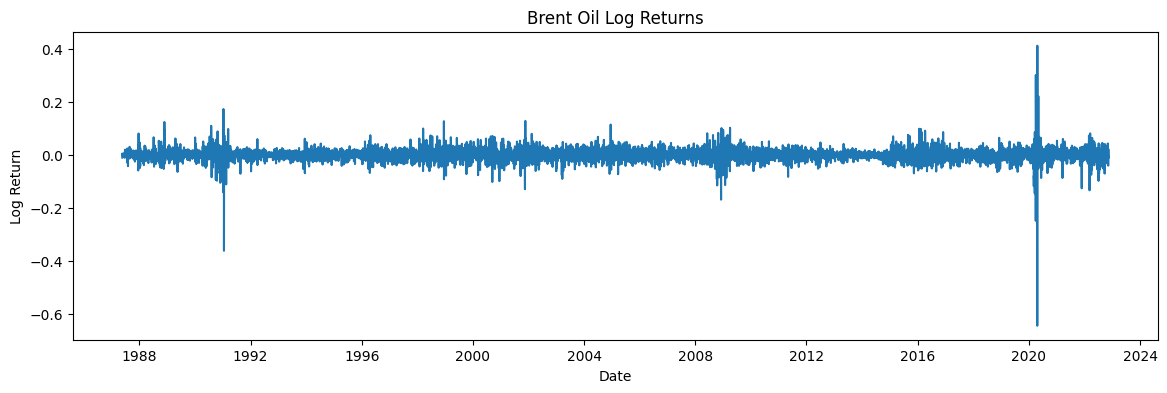

In [8]:
#plot log return
plt.figure(figsize=(14,4))
plt.plot(df.index, df["LogReturn"])
plt.title("Brent Oil Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [10]:
###
#Build Bayesian Change Point Model (PyMC)
###

#Prepare Series for Modeling
import pymc as pm
import numpy as np

# --- Prepare Series for Modeling
y = df["Price"].values[:500]
n = len(y)
x = np.arange(n)

# --- Build Model
with pm.Model() as model:
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n-1)

    mu_1 = pm.Normal("mu_1", mu=np.mean(y), sigma=10)
    mu_2 = pm.Normal("mu_2", mu=np.mean(y), sigma=10)

    sigma = pm.HalfNormal("sigma", sigma=10)

    mu = pm.math.switch(x < tau, mu_1, mu_2)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    step1 = pm.Metropolis(vars=[tau])
    step2 = pm.NUTS(vars=[mu_1, mu_2, sigma])

    trace = pm.sample(
        500,
        tune=500,
        step=[step1, step2],
        cores=2,
        progressbar=True,
        return_inferencedata=True
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 444 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
tau_samples = trace.posterior["tau"].values.flatten()
tau_est = int(tau_samples.mean())
tau_est

233

In [14]:
###
# Interpret the Model Output
###

#Check Convergence
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,233.058,1.354,231.000,235.000,0.111,0.057,147.0,239.0,1.02
mu_1,18.488,0.067,18.368,18.613,0.002,0.002,1003.0,816.0,1.00
mu_2,15.322,0.066,15.208,15.456,0.002,0.002,1347.0,696.0,1.00
sigma,1.080,0.034,1.018,1.142,0.001,0.001,1439.0,730.0,1.00


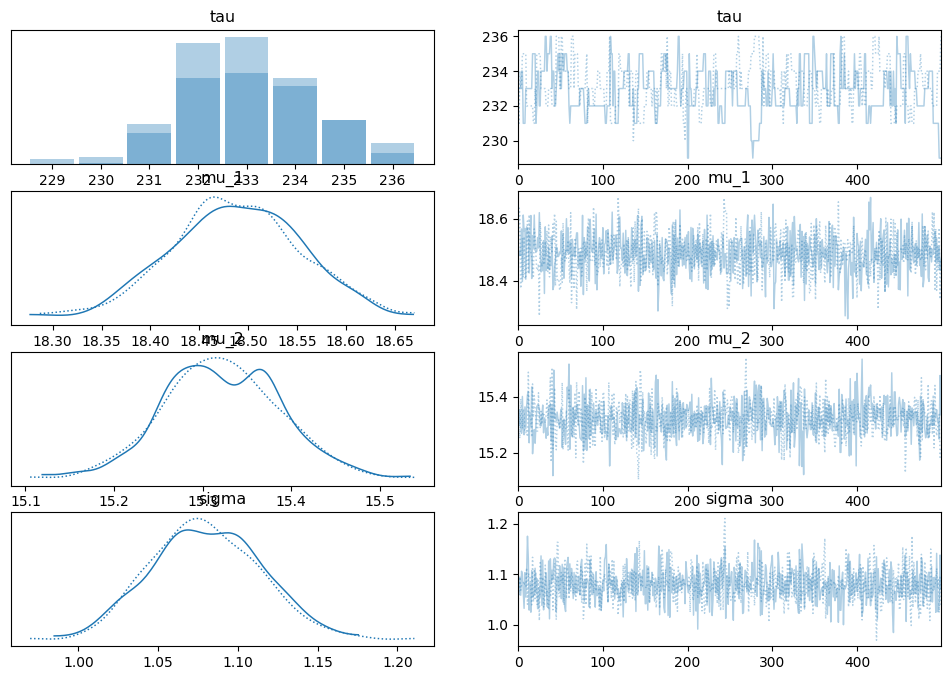

In [15]:
#Trace Plots
az.plot_trace(trace)
plt.show()

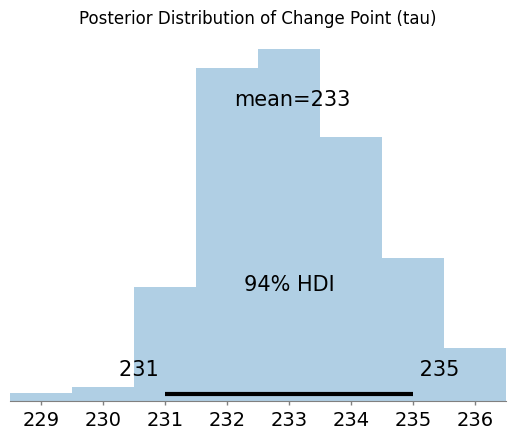

In [16]:
# Posterior of Change Point (τ)
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior Distribution of Change Point (tau)")
plt.show()

In [19]:
# Convert τ to Date
tau_samples = trace.posterior["tau"].values.flatten()
tau_mean = int(tau_samples.mean())

change_date = df.index[tau_mean]

print("Estimated Change Point Index:", tau_mean)
print("Estimated Change Point Date:", change_date)

Estimated Change Point Index: 233
Estimated Change Point Date: 1988-01-09 00:00:00


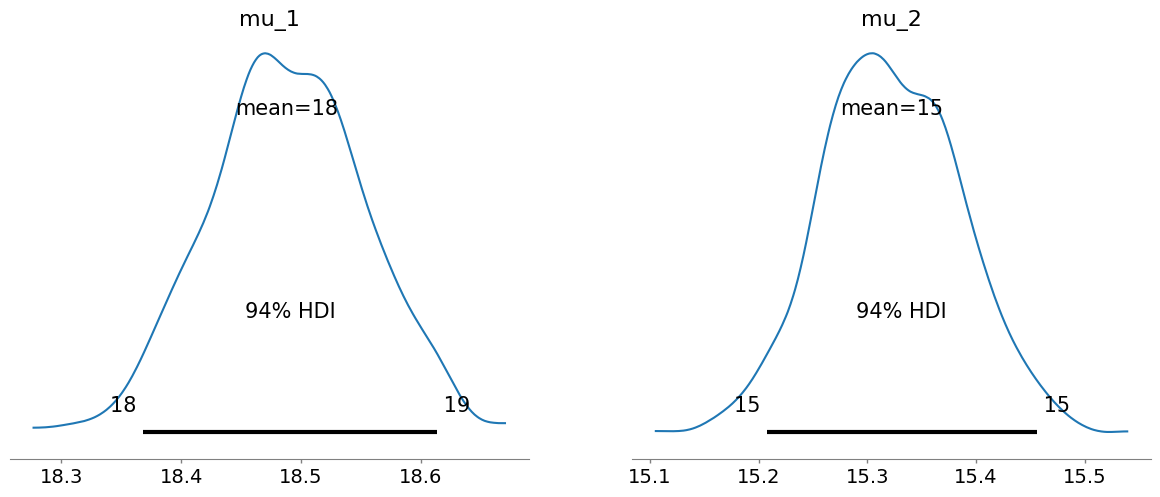

Mean before change: 18.49
Mean after change: 15.32
Impact: -17.12%


In [20]:
#Before vs After Means
az.plot_posterior(trace, var_names=["mu_1", "mu_2"])
plt.show()

mu1 = trace.posterior["mu_1"].mean().values
mu2 = trace.posterior["mu_2"].mean().values

impact_pct = (mu2 - mu1) / mu1 * 100

print(f"Mean before change: {mu1:.2f}")
print(f"Mean after change: {mu2:.2f}")
print(f"Impact: {impact_pct:.2f}%")

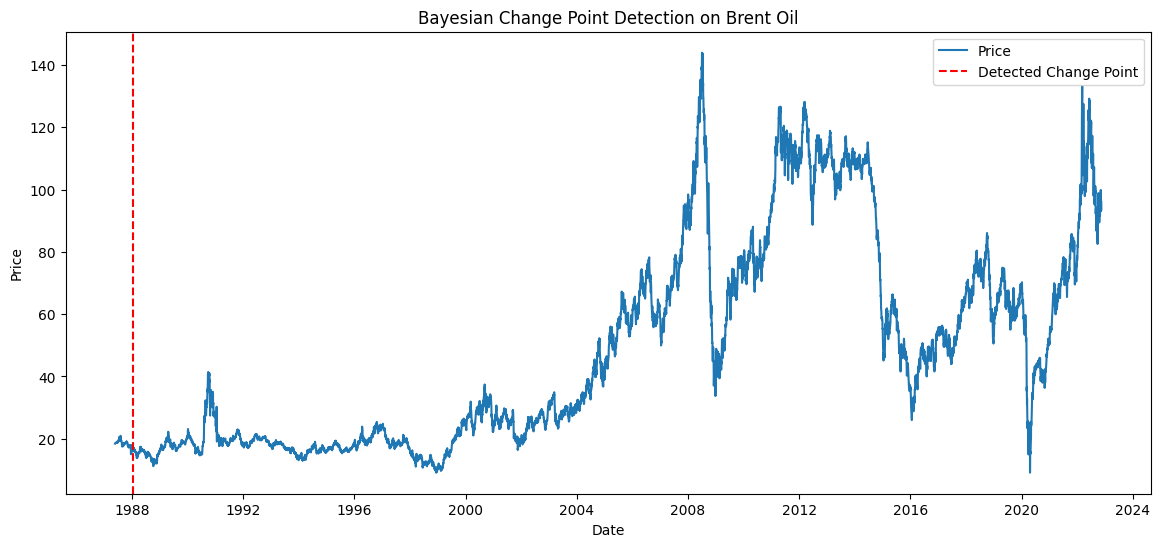

In [21]:
# Visualize Change Point on Price
plt.figure(figsize=(14,6))
plt.plot(df.index, df["Price"], label="Price")
plt.axvline(change_date, color="red", linestyle="--", label="Detected Change Point")

plt.title("Bayesian Change Point Detection on Brent Oil")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# Load events CSV
try:
    events = pd.read_csv("../data/events/events.csv")
    print("Loaded successfully")
except FileNotFoundError:
    print("Error: file not found")

# Convert 'Date' to datetime
events["Date"] = pd.to_datetime(events["Date"])

# Define your change date
change_date = pd.to_datetime("2020-03-11")

# Now calculate distance
events["Distance_Days"] = (events["Date"] - change_date).abs().dt.days

# Sort by closest events
events_sorted = events.sort_values("Distance_Days")
print(events_sorted.head())

Downloaded successfully
        Date                       Event  Distance_Days
5 2020-03-11  COVID-19 declared pandemic              0
6 2020-04-12          OPEC+ historic cut             32
4 2019-09-14       Saudi Aramco attacked            179
7 2021-11-26       Omicron variant shock            625
3 2018-05-08  US exits Iran nuclear deal            673


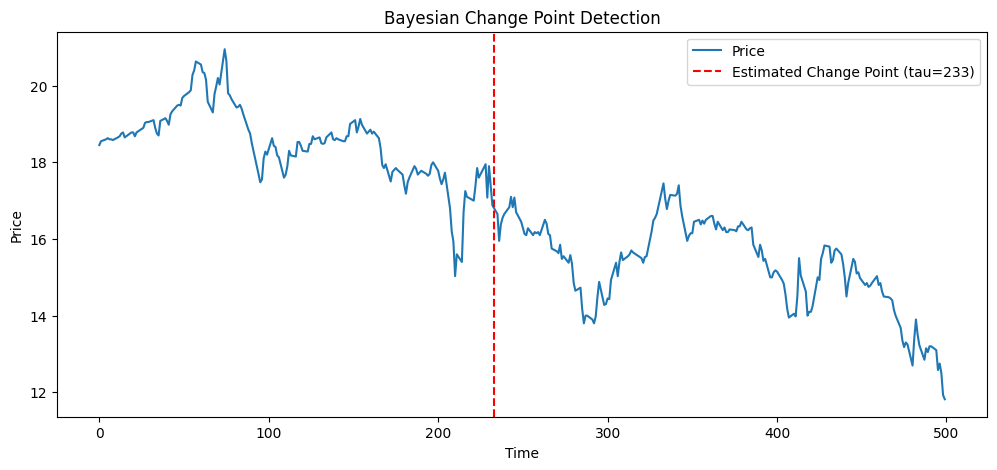

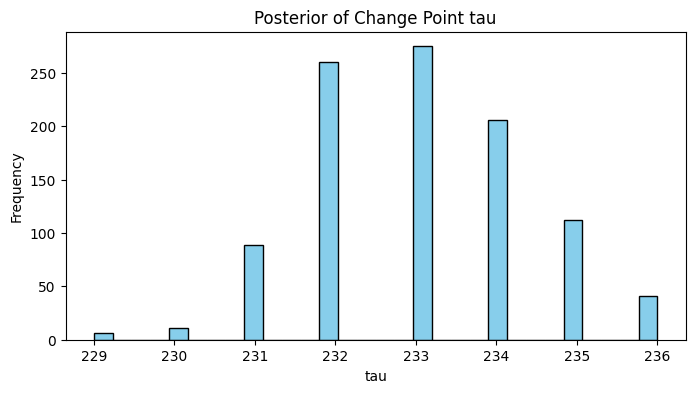

In [ ]:
# Extract posterior of tau
tau_samples = trace.posterior["tau"].values.flatten()
tau_est = int(tau_samples.mean())

# Plot time series with estimated change point
plt.figure(figsize=(12,5))
plt.plot(y, label="Price")
plt.axvline(tau_est, color="red", linestyle="--", label=f"Estimated Change Point (tau={tau_est})")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bayesian Change Point Detection")
plt.legend()
plt.show()

# Optional: visualize posterior distribution of tau
plt.figure(figsize=(8,4))
plt.hist(tau_samples, bins=30, color="skyblue", edgecolor="k")
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.title("Posterior of Change Point tau")
plt.show()
